In [1]:
#  in this notebook varya is trying to implement catboost library for the catchment probability prediction 

In [2]:
# !pip install catboost
# !pip install ipywidgets

# catboost tutorial: 
# https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

# this is also a very nice tutorial 
# https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview/notebook

In [3]:
import catboost
print(catboost.__version__)
!python --version

1.0.6
Python 3.7.11


In [4]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
import matplotlib.pyplot as plt
import geopandas as gpd

# train and test:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score


!jupyter nbextension enable --py widgetsnbextension


# some opinions:
# https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
# read the data: 

path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
# df = pd.read_csv(path + 'dfclim_3aug_rainydays.csv', sep = ',', index_col = 0)
df = pd.read_csv(path + '09082022dfclim_permafrost.csv', sep = ',', index_col = 0)

df = df[df.target.isin([1,0])]
df = df.drop(['DN', 'Name', 'mean_daylymonsoon_tp_x'], axis = 1)


In [8]:
df.columns

print('continious_permafrost_fraction')
print('continious_permafrost')
print('discontinious_permafrost')
print('discontinious_permafrost_fraction')
print('sporadic_permafrost')
print('sporadic_permafrost_fraction')
print('isolated_patches_permafrost')
print('isolated_patches_permafrost_fraction')

continious_permafrost_fraction
continious_permafrost
discontinious_permafrost
discontinious_permafrost_fraction
sporadic_permafrost
sporadic_permafrost_fraction
isolated_patches_permafrost
isolated_patches_permafrost_fraction


In [7]:
# df.columns

df['region_name'].value_counts()

# print('cat features': list(range(0, X.shape[1])))

tadjikistan       233
karakorum         166
chitral            89
eastTSH            84
interior tibet     84
langtang           32
nyanq              24
Name: region_name, dtype: int64

In [11]:
# define X and y 
y = df.target
X = df.drop(columns=['target', 'region_name'])


# # what values are categorical: 
# # region, glacier, avgtemp_belowzero, cont_permafrost, any_permafrost, cont_permafrost_frac50
X['glacier'] = X['glacier'].astype('category') # n 21
X['region'] = X['region'].astype('category') # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype('category') # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype('category') # n 51
X['any_permafrost'] = X['any_permafrost'].astype('category') # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype('category') # n 54



In [12]:
X.columns

# 13, 22, 35, 52, 53, 55 - cat features 

Index(['x_centroid', 'y_centroid', 'area_m', 'perimeter', 'glaciersum',
       'mean_elevation', 'median_elevation', 'std_elevation', 'min_elevation',
       'max_elevation', 'range_elevation', 'variance_elevation', 'region',
       'mean_slope', 'median_slope', 'std_slope', 'min_slope', 'max_slope',
       'range_slope', 'variance_slope', 'glarea_percent', 'glacier', 'x_wgs',
       'y_wgs', 'M', 'Rc', 'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T',
       'mean_monsoon_T', 'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_y', 'mean_monsoon_sum_tp', 'monsoon_tp_frac',
       'n_rainy_days', 'rainy_days_frac', 'permafrost1', 'permafrost1_frac',
       'permafrost2', 'permafrost2_frac', 'permafrost3', 'permafrost3_frac',
       'permafrost4', 'permafrost4_frac', 'cont_permafrost',
       'cont_permafrost_frac50', 'all_permafrost_frac', 'any_permafrost'],
      dtype='object')

In [13]:
# cat features: 
# X.columns
cat_features = list([12, 21, 34, 50, 51, 53])
# type(cat_features)
# cat_features = list(range(0, X.shape[1]))

In [14]:
print('Labels: {}'.format(set(y)))
print('FF (0) count = {}, DF (1) count = {}'.format(len(y) - sum(y), sum(y)))


Labels: {0, 1}
FF (0) count = 173, DF (1) count = 539


# catboost classifier 

### train test 

In [15]:
from sklearn.model_selection import train_test_split

seed = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=test_size, random_state=seed)

## Pool data class (?) 

#### catboost needs data to be stored as a "pool" thing for some functions 

In [16]:
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                 )

test_data = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features,
                 )

### classifier 

In [17]:
from catboost import CatBoostClassifier
# logloss - default(?)
# CrossEntropy - for probabilities 

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    use_best_model= True,
    loss_function='CrossEntropy', 
    custom_loss=['AUC', 'Accuracy']
)


model.fit(
    train_data,                # pool thing - instead of X_train, y_train
    # cat_features=cat_features, # since the data is a pool - it already knows about it 
    eval_set=test_data,        # pool thing - instead of X_test, y_test
    verbose=False, 
    plot=True
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy', 'use_best_model': True, 'custom_loss': ['AUC', 'Accuracy']}


### "coventional" ROC curve

### cross validation 

In [18]:
# %%time
# from catboost import cv


# params = {'loss_function':'Logloss',
#           'eval_metric':'AUC',
#           'verbose': 200,
#           'random_seed': seed
#          }

# all_train_data = Pool(data=X,
#                       label=y,
#                       cat_features=cat_features
#                      )

# scores = cv(pool=all_train_data,
#             params=params, 
#             fold_count=10,
#             seed=seed, 
#             shuffle=True,
#             stratified=True, # if True the folds are made by preserving the percentage of samples for each class
#             plot=True
#            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	test: 0.8189300	best: 0.8189300 (0)	total: 9.65ms	remaining: 9.64s
200:	test: 0.9125514	best: 0.9156379 (131)	total: 806ms	remaining: 3.2s
400:	test: 0.9135802	best: 0.9156379 (131)	total: 1.81s	remaining: 2.71s
600:	test: 0.9146091	best: 0.9156379 (131)	total: 2.86s	remaining: 1.9s
800:	test: 0.9166667	best: 0.9166667 (744)	total: 3.67s	remaining: 911ms
999:	test: 0.9146091	best: 0.9166667 (744)	total: 4.45s	remaining: 0us

bestTest = 0.9166666667
bestIteration = 744

Training on fold [1/10]
0:	test: 0.8127572	best: 0.8127572 (0)	total: 5.67ms	remaining: 5.67s
200:	test: 0.8703704	best: 0.8744856 (173)	total: 857ms	remaining: 3.41s
400:	test: 0.8796296	best: 0.8806584 (337)	total: 1.73s	remaining: 2.58s
600:	test: 0.8786008	best: 0.8827160 (529)	total: 2.48s	remaining: 1.65s
800:	test: 0.8827160	best: 0.8847737 (685)	total: 3.41s	remaining: 846ms
999:	test: 0.8837449	best: 0.8847737 (685)	total: 4.24s	remaining: 0us

bestTest = 0.8847736626
bestIteration = 6

### feature statistics build it plot 

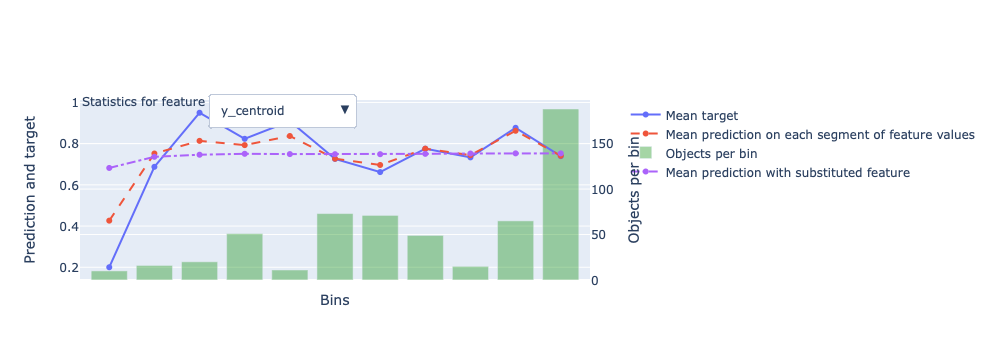

In [19]:
res = model.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                    plot=True)


## model predict probabilities (the entire dataset)

In [20]:
probs = model.predict_proba(X)


### feature importsnce

In [21]:
feature_import = model.get_feature_importance(prettified=True)
feature_import.head()

,Feature Id,Importances
0,M,13.281172
1,mean_slope,12.707453
2,area_m,8.542955
3,y_centroid,6.946484
4,perimeter,6.480112


Text(0.5, 1.0, 'CatBoost features importance:')

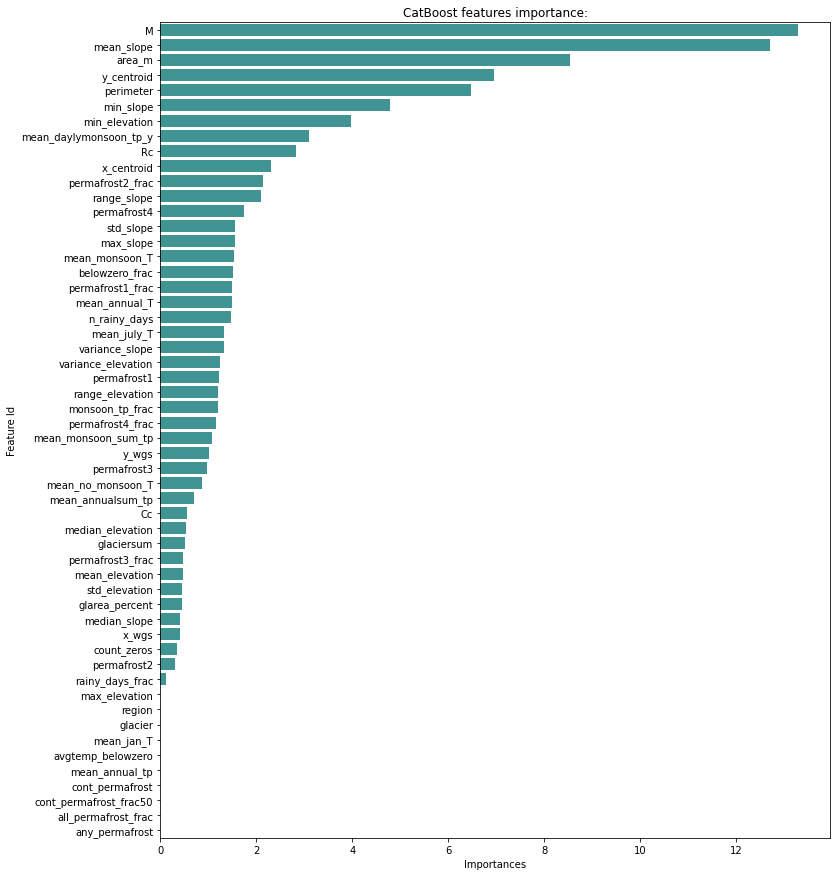

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 15))
sns.barplot(x="Importances", y="Feature Id", data=feature_import, color='darkcyan', alpha = 0.8)
plt.title('CatBoost features importance:')

### shap stuff

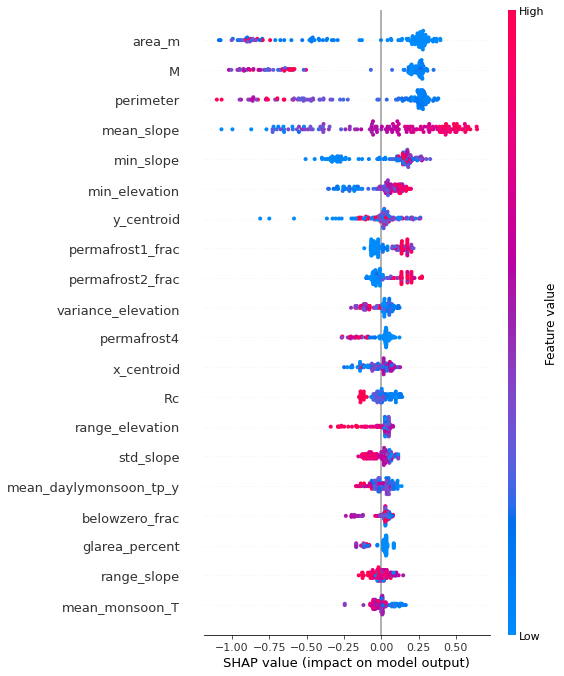

In [38]:
import shap 


explainer = shap.TreeExplainer(model)

shap_valuesX = explainer.shap_values(X)
shap_valuesTR = explainer.shap_values(X_train)
shap_valuesTE = explainer.shap_values(X_test)

# plots:

# shap.summary_plot(shap_valuesX, X)
# shap.summary_plot(shap_valuesTR, X_train)
shap.summary_plot(shap_valuesTE, X_test)


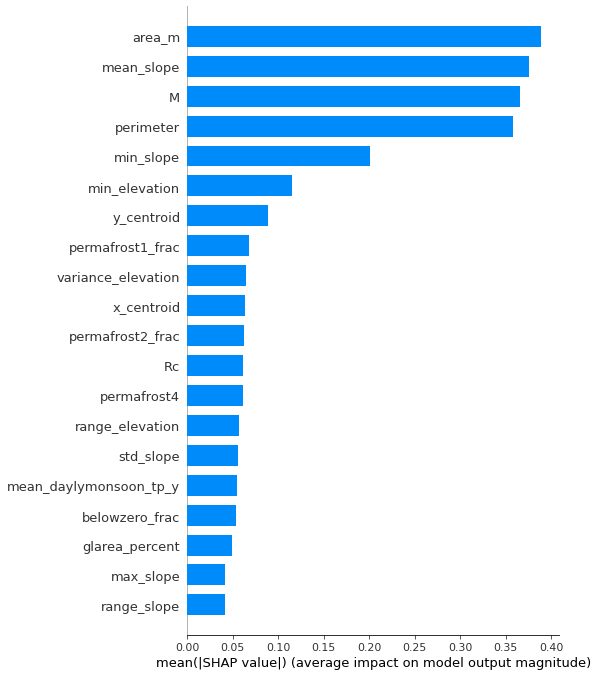

In [24]:
# shap.summary_plot(shap_valuesTE, X_test, plot_type="bar")
# shap.summary_plot(shap_valuesTR, X_train, plot_type="bar")

shap.summary_plot(shap_valuesX, X, plot_type="bar")




In [ ]:
# waterfall plot




### shap and pool: 

In [25]:
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_train.iloc[:500,:])

### apply the model 


In [26]:
y_result = model.predict(X)

y_result_probs = model.predict_proba(X)
y_result_probs = y_result_probs[:,1]

# merge back to the original table

df['y_result'] = y_result
df['y_result_probs'] = y_result_probs

df['result_T'] = df.target + df.y_result # TP = 2, TN = 0
# df['result_F'] = df.target - df.y_result # FP = -1, FN = 1

In [27]:
df['diff_res'] = np.where(df.result_T != 1, df.result_T, (df.target - df.y_result)) 

In [28]:
# read the shape file with geometries 
folder = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/10_datawrangl_formodel!!/shapes/'

geom = pd.DataFrame(gpd.read_file(folder+ 'catchments_points_together.shp'))

geom = geom[['x_centroid', 'y_centroid', 'geometry']].drop_duplicates()

In [29]:
## nerge with dfclim: 

predicted = df.merge(geom, on = ['x_centroid', 'y_centroid'], how = 'left')
predicted_gdf = gpd.GeoDataFrame(predicted, geometry='geometry')

shpout = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/output/'

# predicted_gdf.to_file(shpout + 'dfclim_predicted.shp')  

In [210]:
df.columns

Index(['target', 'x_centroid', 'y_centroid', 'area_m', 'perimeter',
       'glaciersum', 'mean_elevation', 'median_elevation', 'std_elevation',
       'min_elevation', 'max_elevation', 'range_elevation',
       'variance_elevation', 'region', 'region_name', 'mean_slope',
       'median_slope', 'std_slope', 'min_slope', 'max_slope', 'range_slope',
       'variance_slope', 'glarea_percent', 'glacier', 'x_wgs', 'y_wgs', 'M',
       'Rc', 'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T',
       'mean_monsoon_T', 'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_y', 'mean_monsoon_sum_tp', 'monsoon_tp_frac',
       'n_rainy_days', 'rainy_days_frac', 'permafrost1', 'permafrost1_frac',
       'permafrost2', 'permafrost2_frac', 'permafrost3', 'permafrost3_frac',
       'permafrost4', 'permafrost4_frac', 'cont_permafrost',
       'cont_permafrost_frac50', 'all_permafrost_frac', 'any_permafrost',

### partial depend stuff
#### line on the PD plot shows the average value of the model output when we fix the median income feature to a given value

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


(0.0, 1.0)

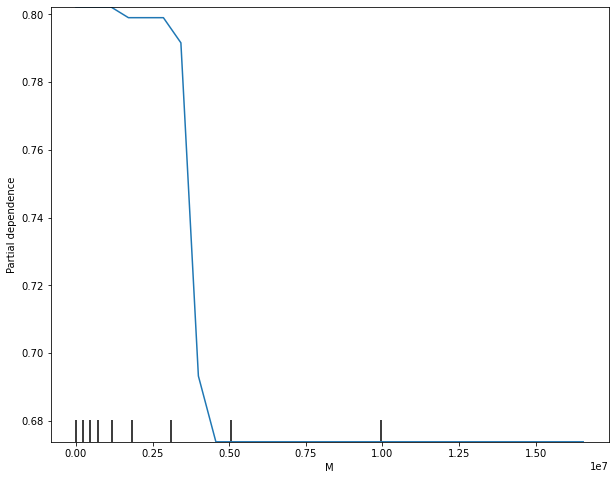

In [30]:
# see this as background: 
# https://christophm.github.io/interpretable-ml-book/pdp.html

from sklearn.inspection import partial_dependence, plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim(0, 1)

my_plots = plot_partial_dependence(model,       
                                   features=['M'],       # column numbers of plots we want to show
                                   X=X,                        # raw predictors data.
                                   grid_resolution=30,
                                   response_method='predict_proba', 
                                   ax=ax)  # number of values to plot on x axis
ax.set_ylim(0, 1)

# plt.savefig('figs/pdp_M_catb.pdf')

In [201]:
X.columns

Index(['x_centroid', 'y_centroid', 'area_m', 'perimeter', 'glaciersum',
       'mean_elevation', 'median_elevation', 'std_elevation', 'min_elevation',
       'max_elevation', 'range_elevation', 'variance_elevation', 'region',
       'mean_slope', 'median_slope', 'std_slope', 'min_slope', 'max_slope',
       'range_slope', 'variance_slope', 'glarea_percent', 'glacier', 'M', 'Rc',
       'Cc', 'mean_annual_T', 'mean_jan_T', 'mean_july_T', 'mean_monsoon_T',
       'mean_no_monsoon_T', 'count_zeros', 'belowzero_frac',
       'avgtemp_belowzero', 'mean_annual_tp', 'mean_annualsum_tp',
       'mean_daylymonsoon_tp_x', 'mean_daylymonsoon_tp_y',
       'mean_monsoon_sum_tp', 'monsoon_tp_frac', 'n_rainy_days',
       'rainy_days_frac'],
      dtype='object')

In [44]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution


shap.partial_dependence_plot(
    "area_m", model.predict_proba, X100)#, ice=False,
    # model_expected_value=True, feature_expected_value=True
# )

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=12]=8.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

### partial dependency 2d 

In [ ]:
# https://scikit-optimize.github.io/stable/auto_examples/plots/partial-dependence-plot-with-categorical.html


